# Sell by Date Identifier
This program was made by Daniel Simons C17371946 and Stephen Creighton C17344841 for the Group Project in Image Processing.

Daniel Simons Blog: https://danraysimons.wordpress.com/

Stephen Creighton Blog: https://c17344841mytudublin.wordpress.com/

# Description
This program is made to allow a user to input an image containing a use by date somewhere within, it takes the image and locates and segments the use by date through Image processing processes. The output will be the located and cropped image of the use by date, this can be used later maybe in OCR software to detect the characters within the text with less issues.

Below you will find instructions for use and the completed code for the program, outputs are located below that again when finished.

# The Algorithm
## Loading in image
1. All cells are ran, all libraries are imported, and all functions are defined
2. Once this is complete the main() function is run, this is where all other functions will be called from
3. In the main function the first thing that happens is an easygui window is opened with a message for the user to tell them what they should do in the next window
4. Another easygui window is opened when the previous is closed this one allows the user to open a picture file to be used in the program
5. The image that was selected is read in as I for ease of use for the developer 
<br><br><br>


## Cropping the lid area
6. The crop_lid() function is run and saved as Cropped_Lid
    * **crop_lid()**
7. We output the process to teh user throughout this program, so a print statement is executed to let the user know what step we are at
8. we make a copy of the Image to allow us to work without ruining the original we have
9. A gaussianBlur is executed here to reduce the noise of the image for the next part, as it will interfere with that
10. Canny edge detection is carried out so that we can use the resulting image to create contours
11. The countours are found using our Canny_Image and the contours are then sorted by size
12. Because we removed the noise and the bottle should be the main thing in the image, the largest contour is highly likely to be the countour we are looking for, we use this information to create a boundingRect() around the largest contour, this is then cropped down to the bindingRect()
13. Now we display the images from this function to the user by plotting them and return the result back to the main
    * **main() again**
<br><br><br>


## Masking the lid area to get the black text
14. The mask_lid() function is ran passing through the Cropped_Lid and saved to Mask
    * **mask_lid()**
15. We again tell the user what we are going to do
16. The image is converted to grayscale, this is defined in a function to allow for easier names for developing
17. We remove the whitest parts from the image, these are not needed as the text is black, we use the threshold values we defined as low and high for the threshold function
18. A region of interest section is extracted as a bitwise image
19. The images are plotted for the user
20. Using our previous ROI we recreate the same steps as before but we remove the blue from the image by changing the threshold values.
21. The steps in this are also displayed to the user here with matplot
22. Remove the blue with the mask
23. Now that the excess information is removed from the image we can use the new ROI we just created to make another ROI of just the text in grayscale.
24. We use the sobel edge detection method to turn our grayscale letters into a binary mask
25. Display these resulting images and return to main()
    * **main() again**
<br><br><br>
    

## Getting the final crop to focus the text
26. get_text() is executed and saved to Final_Crop
    * **get_text()**
27. First of all we let the user know how far along we are with a print statement
28. A copy is created so that the original copy can be drawn on and it will not be in the output image
29. Three Kernels are made for various tasks we are about to complete, these are used for morphology functions
30. MORPH_OPEN is used followed by MORPH_CLOSE and dilate, this results in the text being expanded out so that all the pictures touch and it creates one sort of block of pixels instead of multiple small ones
31. The contours of the resulting image are found, this allows us to find the writing as one object when using the dilated image
32. the contours of the largest contour are drawn, this is taken from the sorted array of contours
33. A boundingRect() is made around this contour giving us pixel values that we can use to crop the original image down to the area of the text, this is our final output image
34. The images are plotted and the final image is saved for the user, we return this image to main()
    * **main() again**
<br><br><br>
    
## Algorithm complete
35. We let the user know we have the image and print it to the screen, then a popup is opened and shown to the user so it is clear that this is the output image they were looking for

# Concepts
* colorspaces
* cropping
* morpholgy
* segmentation
* contours
* masking

# References

**Using easygui**

1.
EasyGui Tutorial — easygui 0.97  (2014-12-20) documentation [Internet]. Pythonhosted.org. 2014 [cited 2020 Nov 26]. Available from: https://pythonhosted.org/easygui/tutorial.html
‌

**Finding contours**

2.
OpenCV: Contours : Getting Started [Internet]. Opencv.org. 2020 [cited 2020 Nov 26]. Available from: https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
‌

**sobel magnitude and edge detection**

3.
OpenCV 3  Image Edge Detection : Sobel and Laplacian - 2020 [Internet]. Bogotobogo.com. 2020 [cited 2020 Nov 26]. Available from: https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php
‌

**Bounding rectangle**

4.
OpenCV: Contour Features [Internet]. Opencv.org. 2020 [cited 2020 Nov 26]. Available from: https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
‌

# Instructions
1. Run the cell/program
2. A popup window will appear with a notice to select an image, click ok
3. select the image you wish to use which contains the mooju lids use by date
4. View the window that pops up for it's main output
5. Other outputs can be viewed at the bottom of the code

### NOTE
All cells have been condensed into one shown here, below the output there will be a view of each function separately.

-----Starting crop_lid function-----
Using canny edge detection on image
Finding contours of image
Creating rectangle that bounds largest contour
Plotting images
Converting image to RGB
Converting image to RGB


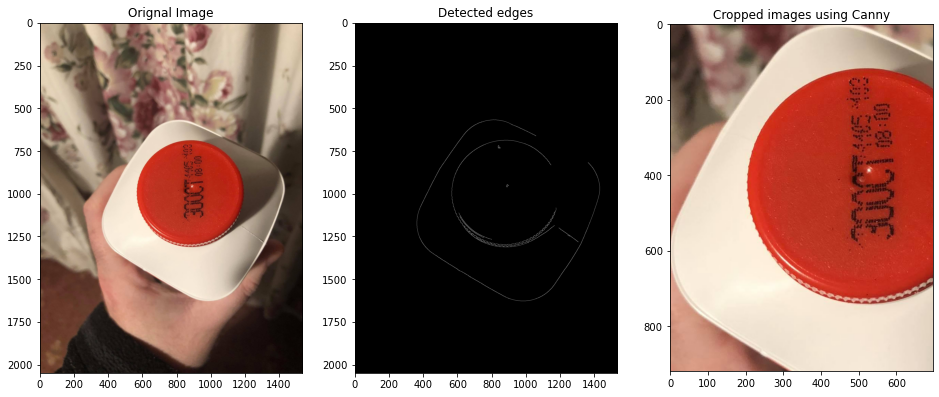

-----Finished crop_lid function-----
-----Starting mask_lid function-----
Removing white from image
Converting image to Grayscale
Finding the threshold of image using multiple thesholding
Plotting images
Converting image to RGB
Converting image to RGB


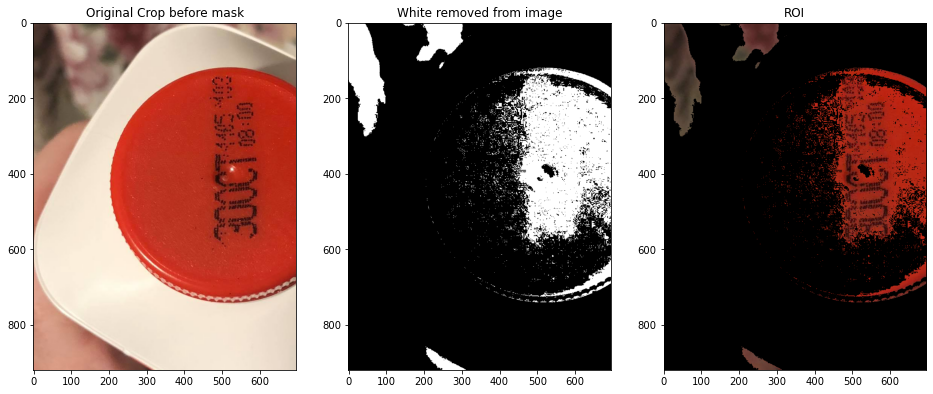

Removing blue from image
Converting image to Grayscale
Finding the threshold of image using multiple thesholding
Plotting images


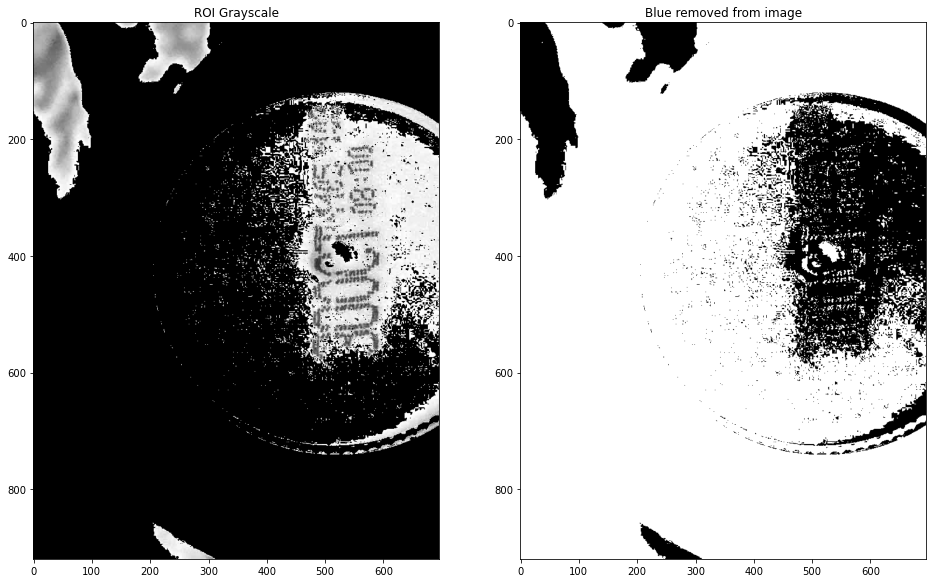

Isolating text from image
Converting image to Grayscale
Using sobel edge detection on image
Plotting images
Converting image to RGB


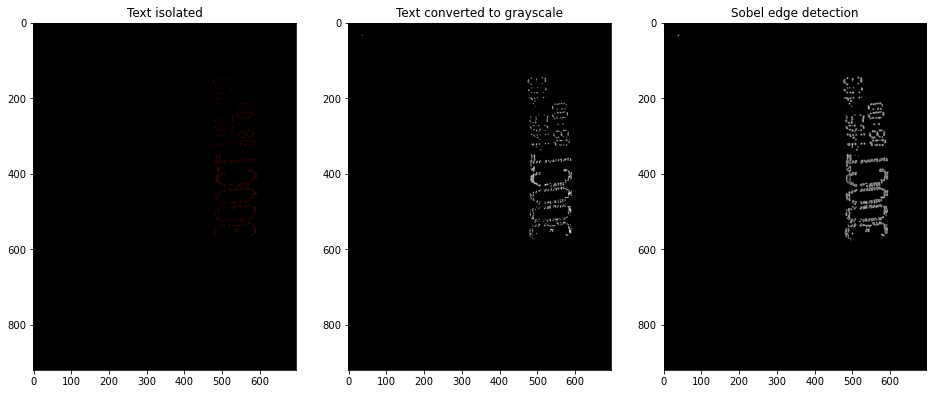

-----Finished mask_lid function-----
-----Starting get_text function-----
Starting morphology operations
Plotting images
Converting image to RGB


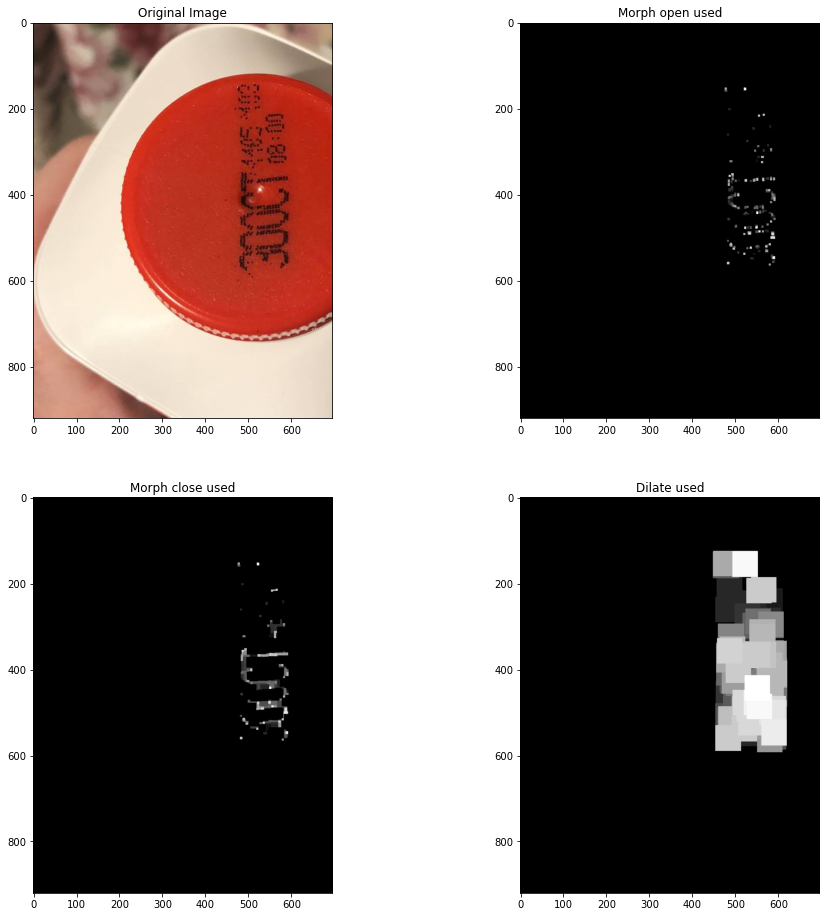

Finding contours of morphed image
Drawing contours and cropping image to contour size
Plotting images
Converting image to RGB
Converting image to RGB
Converting image to RGB


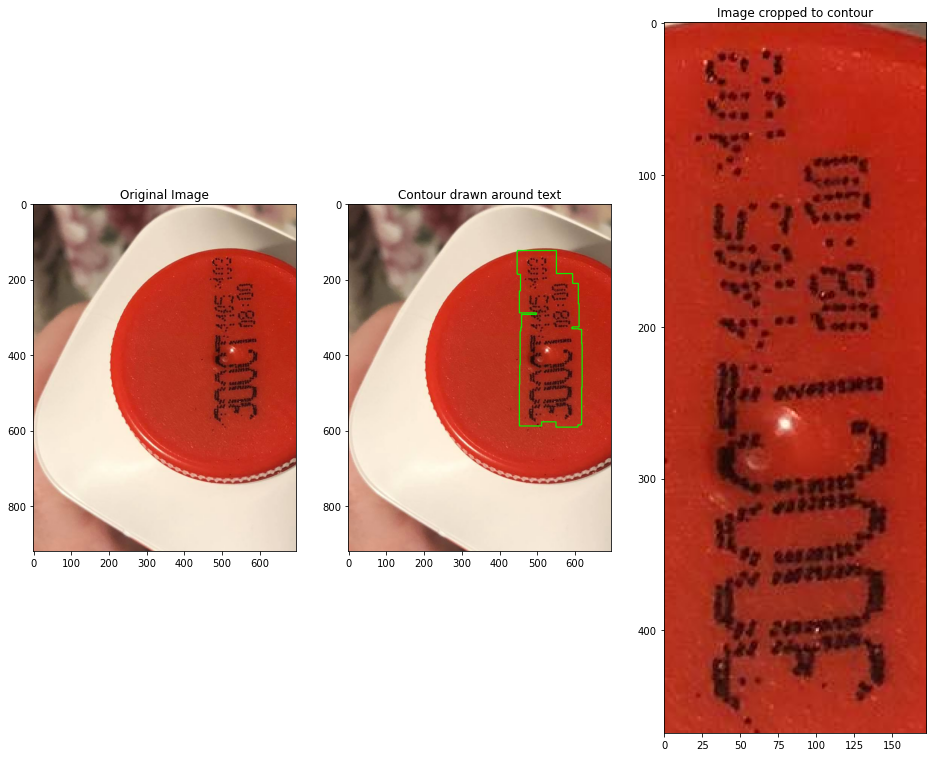

-----Finished get_text function-----
Displaying text found in image!
Window opened!
Window closed


In [9]:
#Imports
import cv2
import glob
import numpy as np 
from matplotlib import pyplot as plot 
from matplotlib import image as image
import easygui #(1)

def image_viewer_popout(imagename, img):
    print("Window opened!")
    cv2.imshow(imagename, img)
    key = cv2.waitKey(0)
    print("Window closed")

def convert_To_RGB(img):
    print("Converting image to RGB")
    RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return RGB

def convert_To_GrayScale(img):
    print("Converting image to Grayscale")
    GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return GRAY

def canny_edge_Detection(I, lowvalue, highvalue):
    print("Using canny edge detection on image")
    FilteredImage = cv2.Canny(I, threshold1=lowvalue, threshold2=highvalue)
    return FilteredImage

def sobel_edge_detection(I):
    print("Using sobel edge detection on image")
    Ix = cv2.Sobel(I,ddepth=cv2.CV_64F,dx=1,dy=0)
    Iy = cv2.Sobel(I,ddepth=cv2.CV_64F,dx=0,dy=1)
    FilteredImage = cv2.magnitude(Ix, Iy)
    return FilteredImage


def calc_subplot(amount):
    if amount == 1:
        return 1,1
    
    for i in range(1,amount):
        if amount % i == 0:
            cols = int(amount / i)
            rows = i
    
    return rows, cols

def subplot_images(Images, Titles):
    print("Plotting images")
    amount = len(Images)
    rows, columns  = calc_subplot(amount)

    fig=plot.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if(len(Images[i-1].shape)!=3):
            plot.imshow(Images[i-1], cmap='gray')
            plot.title(Titles[i-1])
        else:
            plot.imshow(convert_To_RGB(Images[i-1]))
            plot.title(Titles[i-1])
    plot.show()
    

def multiple_thresholding(I, rangelower, rangehigher):
    print("Finding the threshold of image using multiple thesholding")
    B = cv2.inRange(I, rangelower, rangehigher)
    return B

def main():
    easygui.msgbox("Please select a image") #(1)
    f = easygui.fileopenbox()

    if(f == None ):
        while(f == None):
            print("Error reading in file")
            easygui.msgbox("Please select a file") #(1)
            f = easygui.fileopenbox()
        
    I = cv2.imread(f)    
    Cropped_Lid = crop_lid(I)
    Mask = mask_lid(Cropped_Lid)
    Final_Crop = get_text(Mask, Cropped_Lid)
    
    print("Displaying text found in image!")
    image_viewer_popout("Text Found", Final_Crop)

def crop_lid(Mooju):
    print("-----Starting crop_lid function-----")
    I = Mooju.copy()
    Blurred = cv2.GaussianBlur(I, (7,7), 0)
    Cannny_Image = canny_edge_Detection(Blurred, 0, 255)
    
    print("Finding contours of image")#(2)
    contours,_ = cv2.findContours(Cannny_Image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    print("Creating rectangle that bounds largest contour")
    x,y,w,h = cv2.boundingRect(contours[0]) #(4)
    crop_img = I[y:y+h, x:x+w]
    
    subplot_images([I, Cannny_Image, crop_img], ["Orignal Image", "Detected edges", "Cropped images using Canny"])
    print("-----Finished crop_lid function-----")
    return crop_img

def mask_lid(Cropped):
    print("-----Starting mask_lid function-----")
    #First remove white from mooju bottle
    print("Removing white from image")
    GRAY = convert_To_GrayScale(Cropped)
    low = 85
    high = 255
    remove_white_mask = multiple_thresholding(GRAY, low, high)
    white_removed = cv2.bitwise_not(remove_white_mask)
    ROI = cv2.bitwise_and(Cropped,Cropped,mask=white_removed)
    subplot_images([Cropped, white_removed, ROI], ["Original Crop before mask", "White removed from image", "ROI"])

    #Remove blue from mooju bottle
    print("Removing blue from image")
    GRAYROI = convert_To_GrayScale(ROI)
    low = 30
    high = 255
    remove_blue_mask = multiple_thresholding(GRAYROI, low, high)
    remove_blue_mask = ~remove_blue_mask
    subplot_images([GRAYROI, remove_blue_mask], ["ROI Grayscale", "Blue removed from image"])
    
    #Get the text as your region of interest
    print("Isolating text from image")
    Text_ROI = cv2.bitwise_and(ROI, ROI, mask=remove_blue_mask)
    GRAY_Text_ROI = convert_To_GrayScale(Text_ROI)
    Sobel_Img = sobel_edge_detection(GRAY_Text_ROI) #(3)
    subplot_images([Text_ROI, GRAY_Text_ROI, Sobel_Img], ["Text isolated", "Text converted to grayscale", "Sobel edge detection"])
    
    print("-----Finished mask_lid function-----")
    return Sobel_Img

def get_text(Mask, Original):
    print("-----Starting get_text function-----")
    print("Starting morphology operations")
    Copy = Original.copy()
    kernel = np.ones((3,3), np.uint8)
    kernel2 = np.ones((5,5), np.uint8)
    kernel3 = np.ones((19,19), np.uint8)
    opening = cv2.morphologyEx(Mask, cv2.MORPH_OPEN, kernel, iterations = 2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2, iterations = 4)
    dilate = cv2.dilate(closing, kernel3, iterations = 3)
    dilate = dilate.astype(np.uint8)
    subplot_images([Copy, opening, closing, dilate], ["Original Image", "Morph open used", "Morph close used", "Dilate used"])
    
    print("Finding contours of morphed image")#(2)
    contours,_ = cv2.findContours(dilate, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE) #(2)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    print("Drawing contours and cropping image to contour size")
    Example_Copy = Copy.copy()
    Example_Copy = cv2.drawContours(Example_Copy, contours, 0, color=(0,255,0), thickness=2)
    x,y,w,h = cv2.boundingRect(contours[0]) #(4)
    Copy = Copy[y:y+h,x:x+w]
    
    subplot_images([Original, Example_Copy, Copy], ["Original Image", "Contour drawn around text", "Image cropped to contour"])
    cv2.imwrite("Text.jpg", Copy)
    print("-----Finished get_text function-----")
    return Copy

def testmain():
    I = cv2.imread("./Images/MoojuLids/mooju3.jpg")

    Cropped, contour = crop_lid(I)
    Mask = mask_lid(Cropped)
    get_text(Mask, Cropped)
    
    subplot_images([I, Cropped])
    
#This runs when program is started
if __name__ == "__main__":
    main()

#This is for testing all lids 
#     MoojuLids = [cv2.imread(file) for file in glob.glob("./Images/MoojuLids/*.jpg")]
#     for Mooju in MoojuLids:
#     testmain()

        

<h1>Collection of functions</h1>
<h2>These are the functions separated out for readability</h2>

In [ ]:
# #Imports
# import cv2
# import glob
# import numpy as np 
# from matplotlib import pyplot as plot 
# from matplotlib import image as image
# import easygui #(1)

In [2]:
# def image_viewer_popout(imagename, img):
#     print("Window opened!")
#     cv2.imshow(imagename, img)
#     key = cv2.waitKey(0)
#     print("Window closed")

# def convert_To_RGB(img):
#     print("Converting image to RGB")
#     RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     return RGB

# def convert_To_GrayScale(img):
#     print("Converting image to Grayscale")
#     GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     return GRAY

# def canny_edge_Detection(I, lowvalue, highvalue):
#     print("Using canny edge detection on image")
#     FilteredImage = cv2.Canny(I, threshold1=lowvalue, threshold2=highvalue)
#     return FilteredImage

# def sobel_edge_detection(I):
#     print("Using sobel edge detection on image")
#     Ix = cv2.Sobel(I,ddepth=cv2.CV_64F,dx=1,dy=0)
#     Iy = cv2.Sobel(I,ddepth=cv2.CV_64F,dx=0,dy=1)
#     FilteredImage = cv2.magnitude(Ix, Iy)
#     return FilteredImage


# def calc_subplot(amount):
#     if amount == 1:
#         return 1,1
    
#     for i in range(1,amount):
#         if amount % i == 0:
#             cols = int(amount / i)
#             rows = i
    
#     return rows, cols

# def subplot_images(Images, Titles):
#     print("Plotting images")
#     amount = len(Images)
#     rows, columns  = calc_subplot(amount)

#     fig=plot.figure(figsize=(16, 16))
#     for i in range(1, columns*rows +1):
#         fig.add_subplot(rows, columns, i)
#         if(len(Images[i-1].shape)!=3):
#             plot.imshow(Images[i-1], cmap='gray')
#             plot.title(Titles[i-1])
#         else:
#             plot.imshow(convert_To_RGB(Images[i-1]))
#             plot.title(Titles[i-1])
#     plot.show()
    

# def multiple_thresholding(I, rangelower, rangehigher):
#     print("Finding the threshold of image using multiple thesholding")
#     B = cv2.inRange(I, rangelower, rangehigher)
#     return B

<h1>main function</h1>

In [3]:
# def main():
#     easygui.msgbox("Please select a image") #(1)
#     f = easygui.fileopenbox()

#     if(f == None ):
#         while(f == None):
#             print("Error reading in file")
#             easygui.msgbox("Please select a file") #(1)
#             f = easygui.fileopenbox()
        
#     I = cv2.imread(f)    
#     Cropped_Lid = crop_lid(I)
#     Mask = mask_lid(Cropped_Lid)
#     Final_Crop = get_text(Mask, Cropped_Lid)
    
#     print("Displaying text found in image!")
#     image_viewer_popout("Text Found", Final_Crop)

<h1>crop_lid function</h1>

In [4]:
# def crop_lid(Mooju):
#     print("-----Starting crop_lid function-----")
#     I = Mooju.copy()
#     Blurred = cv2.GaussianBlur(I, (7,7), 0)
#     Cannny_Image = canny_edge_Detection(Blurred, 0, 255)
    
#     print("Finding contours of image")#(2)
#     contours,_ = cv2.findContours(Cannny_Image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
#     contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
#     print("Creating rectangle that bounds largest contour")
#     x,y,w,h = cv2.boundingRect(contours[0]) #(4)
#     crop_img = I[y:y+h, x:x+w]
    
#     subplot_images([I, Cannny_Image, crop_img], ["Orignal Image", "Detected edges", "Cropped images using Canny"])
#     print("-----Finished crop_lid function-----")
#     return crop_img

<h1>mask_lid function</h1>

In [5]:
# def mask_lid(Cropped):
#     print("-----Starting mask_lid function-----")
#     #First remove white from mooju bottle
#     print("Removing white from image")
#     GRAY = convert_To_GrayScale(Cropped)
#     low = 85
#     high = 255
#     remove_white_mask = multiple_thresholding(GRAY, low, high)
#     white_removed = cv2.bitwise_not(remove_white_mask)
#     ROI = cv2.bitwise_and(Cropped,Cropped,mask=white_removed)
#     subplot_images([Cropped, white_removed, ROI], ["Original Crop before mask", "White removed from image", "ROI"])

#     #Remove blue from mooju bottle
#     print("Removing blue from image")
#     GRAYROI = convert_To_GrayScale(ROI)
#     low = 30
#     high = 255
#     remove_blue_mask = multiple_thresholding(GRAYROI, low, high)
#     remove_blue_mask = ~remove_blue_mask
#     subplot_images([GRAYROI, remove_blue_mask], ["ROI Grayscale", "Blue removed from image"])
    
#     #Get the text as your region of interest
#     print("Isolating text from image")
#     Text_ROI = cv2.bitwise_and(ROI, ROI, mask=remove_blue_mask)
#     GRAY_Text_ROI = convert_To_GrayScale(Text_ROI)
#     Sobel_Img = sobel_edge_detection(GRAY_Text_ROI) #(3)
#     subplot_images([Text_ROI, GRAY_Text_ROI, Sobel_Img], ["Text isolated", "Text converted to grayscale", "Sobel edge detection"])
    
#     print("-----Finished mask_lid function-----")
#     return Sobel_Img

<h1>get_text function</h1>

In [6]:
# def get_text(Mask, Original):
#     print("-----Starting get_text function-----")
#     print("Starting morphology operations")
#     Copy = Original.copy()
#     kernel = np.ones((3,3), np.uint8)
#     kernel2 = np.ones((5,5), np.uint8)
#     kernel3 = np.ones((19,19), np.uint8)
#     opening = cv2.morphologyEx(Mask, cv2.MORPH_OPEN, kernel, iterations = 2)
#     closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2, iterations = 4)
#     dilate = cv2.dilate(closing, kernel3, iterations = 3)
#     dilate = dilate.astype(np.uint8)
#     subplot_images([Copy, opening, closing, dilate], ["Original Image", "Morph open used", "Morph close used", "Dilate used"])
    
#     print("Finding contours of morphed image")#(2)
#     contours,_ = cv2.findContours(dilate, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE) #(2)
#     contours = sorted(contours, key=cv2.contourArea, reverse=True)
#     print("Drawing contours and cropping image to contour size")
#     Example_Copy = Copy.copy()
#     Example_Copy = cv2.drawContours(Example_Copy, contours, 0, color=(0,255,0), thickness=2)
#     x,y,w,h = cv2.boundingRect(contours[0]) #(4)
#     Copy = Copy[y:y+h,x:x+w]
    
#     subplot_images([Original, Example_Copy, Copy], ["Original Image", "Contour drawn around text", "Image cropped to contour"])
#     cv2.imwrite("Text.jpg", Copy)
#     print("-----Finished get_text function-----")
#     return Copy